In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Lettura dei dati e creazione dei dataframe per i giocatori, i tornei e i match ATP dal 1968 al 2024 
atp_matches = pd.read_csv('Data/atpdata/atp_matches.csv')
atp_players = pd.read_csv('Data/atpdata/atp_players.csv')
atp_rankings = pd.read_csv('Data/atpdata/atp_rankings.csv', low_memory=False);

#Pallet di colori per i grafici
colors = ['#11565c', '#007660', '#459146', '#9aa414', '#ffa600' ]

## Panoramica sugli attributi dei giocatori

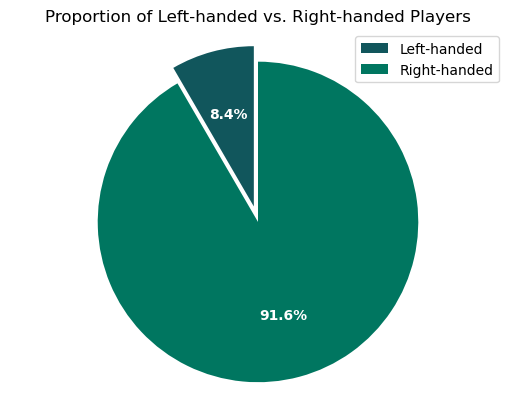

In [4]:
left_handed_count = atp_players['hand'].value_counts()['L']
right_handed_count = atp_players['hand'].value_counts()['R']

hand_counts = pd.DataFrame({'Count': [left_handed_count, right_handed_count]}, index=['Left-handed', 'Right-handed'])

explode = (0.1, 0)

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(hand_counts['Count'], labels=None, colors=colors, explode=explode, startangle=90, autopct='%1.1f%%', textprops=dict(color="white"))
ax.axis('equal')
ax.set_title('Proportion of Left-handed vs. Right-handed Players')

total_count = hand_counts['Count'].sum()
percentages = hand_counts['Count'] / total_count * 100
labels = ['Left-handed', 'Right-handed']
ax.legend(labels, loc='best')
plt.setp(autotexts, size=10, weight="bold")


plt.show()

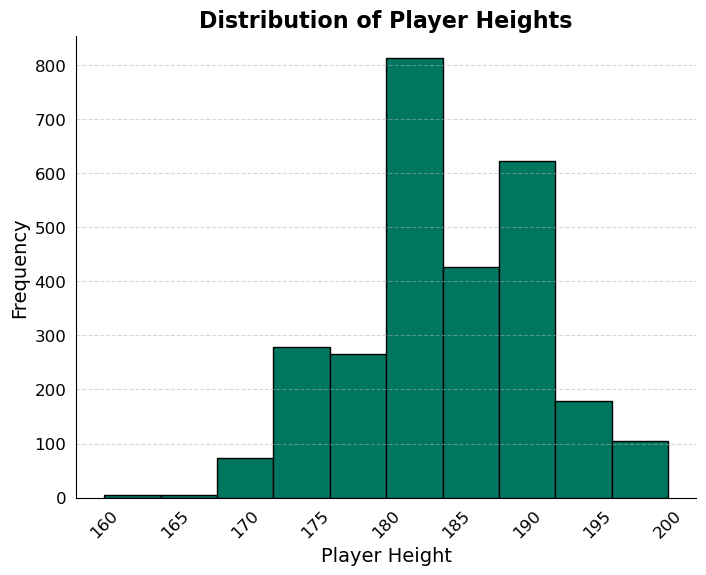

In [5]:
plt.figure(figsize=(8, 6))

filtered_heights = atp_players[atp_players['height'] >= 160]['height']

plt.hist(filtered_heights, bins=10, range=(160, 200), color=colors[1], edgecolor='black', align='mid')

plt.xlabel('Player Height', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Player Heights', fontsize=16, fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tick_params(axis='both', which='both', bottom=False, left=False, labelsize=12)

plt.xticks(rotation=45)

plt.show()

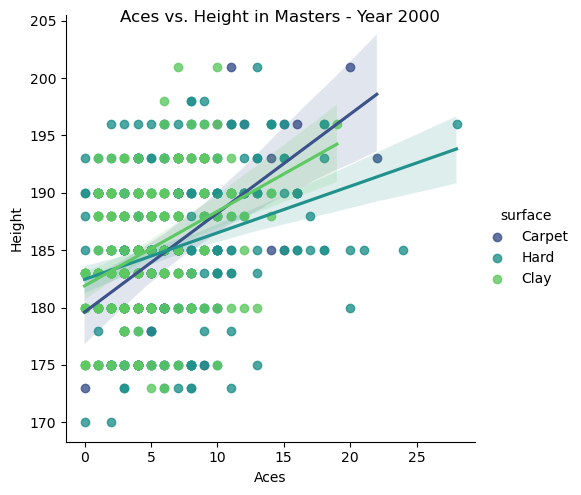

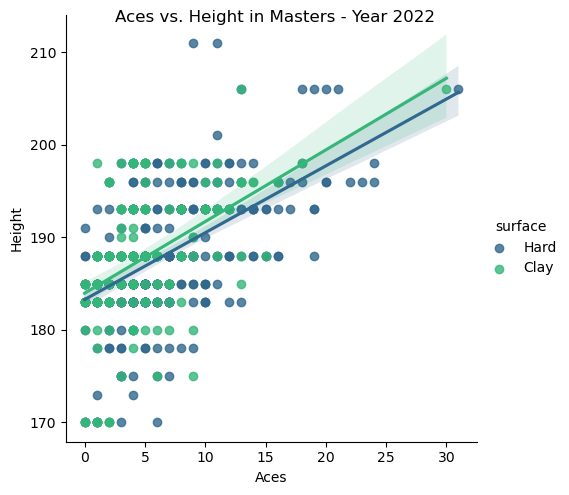

In [6]:
# LA LEGENDA É DA MIGLIORARE
atp_matches['tourney_yearmonth'] = atp_matches.tourney_date.astype(str).str[:6]
atp_matches['tourney_year'] = atp_matches.tourney_date.astype(str).str[:4]
atp_matches['tourney_year'] = atp_matches['tourney_year'].astype(int)

g1 = sns.lmplot(x='w_ace', y='winner_ht', hue='surface', fit_reg=True, data=atp_matches[(atp_matches['tourney_level'].isin(['M']))&(atp_matches['tourney_year']==2000)], palette='viridis')
g1.figure.suptitle('Aces vs. Height in Masters - Year 2000') 
g1.set(xlabel='Aces', ylabel='Height')

g2 = sns.lmplot(x='w_ace', y='winner_ht', hue='surface', fit_reg=True, data=atp_matches[(atp_matches['tourney_level'].isin(['M']))&(atp_matches['tourney_year']==2022)], palette='viridis')
g2.figure.suptitle('Aces vs. Height in Masters - Year 2022')
g2.set(xlabel='Aces', ylabel='Height')


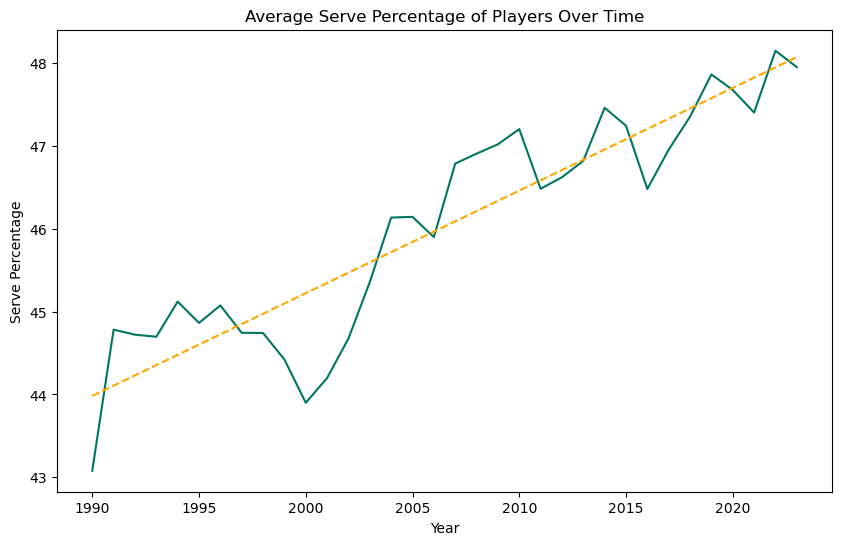

In [7]:
serve_percentage = atp_matches.groupby('tourney_year')['w_1stWon'].sum() / atp_matches.groupby('tourney_year')['w_svpt'].sum() * 100
serve_percentage.plot(kind='line', figsize=(10, 6), color=colors[1])
plt.xlabel('Year')
plt.ylabel('Serve Percentage')
plt.title('Average Serve Percentage of Players Over Time')

x = serve_percentage.index.values
y = serve_percentage.values
coefficients = np.polyfit(x, y, 1)
trend_line = np.poly1d(coefficients)

plt.plot(x, trend_line(x), color=colors[4], linestyle='--')

plt.show()

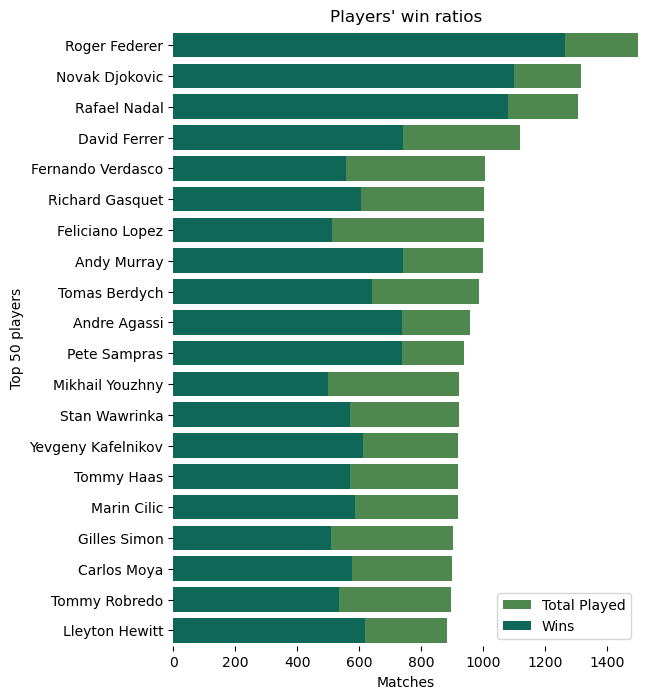

In [8]:
df_win_players = atp_matches.groupby(['winner_name']).agg({'tourney_id':'count','tourney_year':'max'}).reset_index()[['winner_name','tourney_id','tourney_year']]
df_win_players.columns = ['player_name','total_won','tourney_year']
df_win_players['year_period'] = pd.cut(df_win_players.tourney_year.astype(int), [1968, 1979, 1989, 1999, 2009, np.inf], labels=['1970s','1980s','1990s','2000s','2010s'])

df_lost_players = atp_matches.groupby(['loser_name']).agg({'tourney_id':'count','tourney_year':'max'}).reset_index()[['loser_name','tourney_id','tourney_year']]
df_lost_players.columns = ['player_name','total_lost','tourney_year']
df_lost_players['year_period'] = pd.cut(df_lost_players.tourney_year.astype(int), [1968, 1979, 1989, 1999, 2009, np.inf], labels=['1970s','1980s','1990s','2000s', '2010s'])


dfs_players = (df_win_players, df_lost_players)
dfs_players_concat = pd.concat(dfs_players, sort=False)


dfs_players_final = dfs_players_concat.groupby(['player_name','year_period']).agg({'total_won':'sum','total_lost':'sum'}).fillna(0).reset_index()

dfs_players_final['total_played'] = dfs_players_final['total_won']+dfs_players_final['total_lost']
dfs_players_final['win_ratio'] = dfs_players_final['total_won']/(dfs_players_final['total_won']+dfs_players_final['total_lost'])

dfs_players_top = dfs_players_final.sort_values(['total_played'],ascending=False).head(20)

f, ax = plt.subplots(figsize=(6, 8))

sns.set_color_codes("pastel")
sns.barplot(x="total_played", y="player_name", data=dfs_players_top, label="Total Played", color=colors[2])

sns.set_color_codes("muted")
sns.barplot(x="total_won", y="player_name", data=dfs_players_top, label="Wins", color=colors[1])

ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 1500), ylabel="Top 50 players",
       xlabel="Matches", title="Players' win ratios")
sns.despine(left=True, bottom=True)

## Età

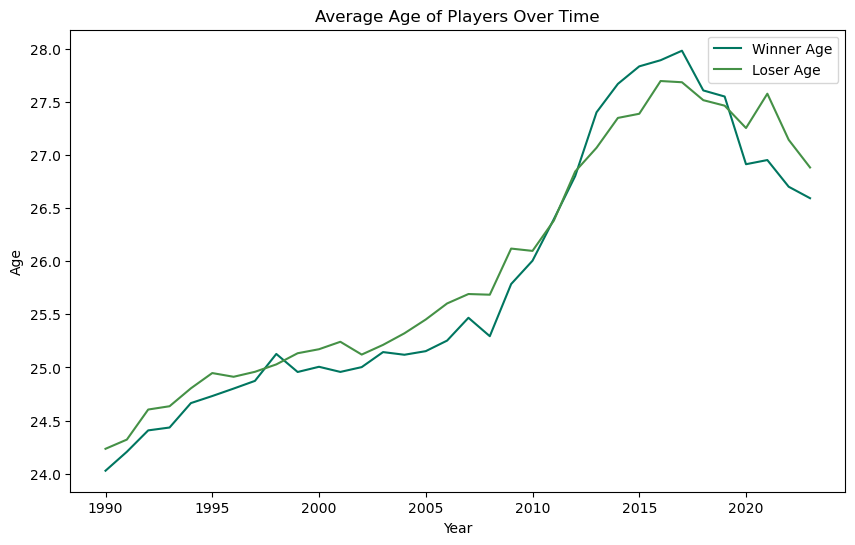

In [9]:
atp_matches['winner_age'] = atp_matches['winner_age'].astype(float)
atp_matches['loser_age'] = atp_matches['loser_age'].astype(float)

winner_ages = atp_matches.groupby('tourney_year')['winner_age'].mean()
loser_ages = atp_matches.groupby('tourney_year')['loser_age'].mean()

plt.figure(figsize=(10, 6))
plt.plot(winner_ages.index, winner_ages.values, color=colors[1], label='Winner Age')
plt.plot(loser_ages.index, loser_ages.values, color=colors[2], label='Loser Age')

plt.xlabel('Year')
plt.ylabel('Age')
plt.title('Average Age of Players Over Time')
plt.legend()

plt.show()

Zoom degli ultimi anni

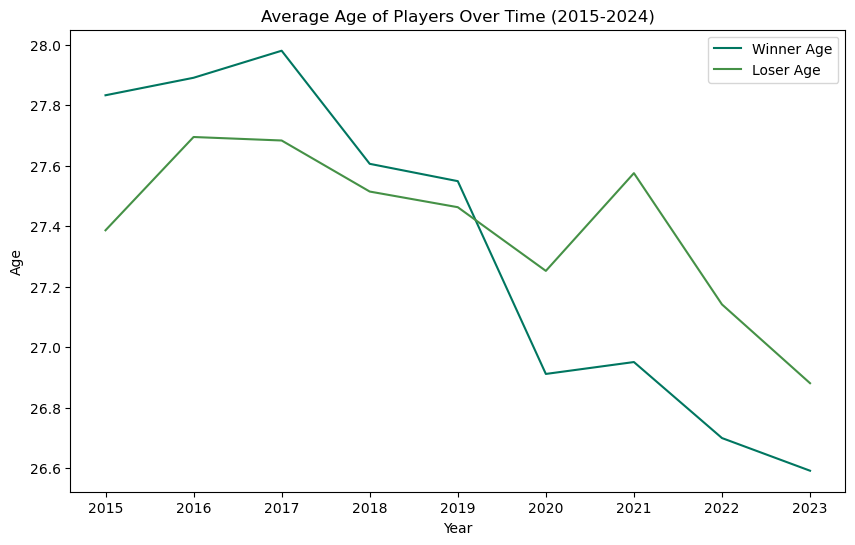

In [10]:
atp_matches['tourney_year'] = atp_matches['tourney_year'].astype(int)
atp_matches['winner_age'] = atp_matches['winner_age'].astype(float)
atp_matches['loser_age'] = atp_matches['loser_age'].astype(float)

atp_matches_2015 = atp_matches[atp_matches['tourney_year'] >= 2015]

winner_ages_2015 = atp_matches_2015.groupby('tourney_year')['winner_age'].mean()
loser_ages_2015 = atp_matches_2015.groupby('tourney_year')['loser_age'].mean()

plt.figure(figsize=(10, 6))
plt.plot(winner_ages_2015.index, winner_ages_2015.values, color=colors[1], label='Winner Age')
plt.plot(loser_ages_2015.index, loser_ages_2015.values, color=colors[2], label='Loser Age')

plt.xlabel('Year')
plt.ylabel('Age')
plt.title('Average Age of Players Over Time (2015-2024)')
plt.legend()

plt.show()

([<matplotlib.axis.XTick at 0x2a51ff16750>,
 [Text(1990, 0, '1990'),
  Text(1995, 0, '1995'),
  Text(2000, 0, '2000'),
  Text(2005, 0, '2005'),
  Text(2010, 0, '2010'),
  Text(2015, 0, '2015'),
  Text(2020, 0, '2020'),
  Text(2025, 0, '2025')])

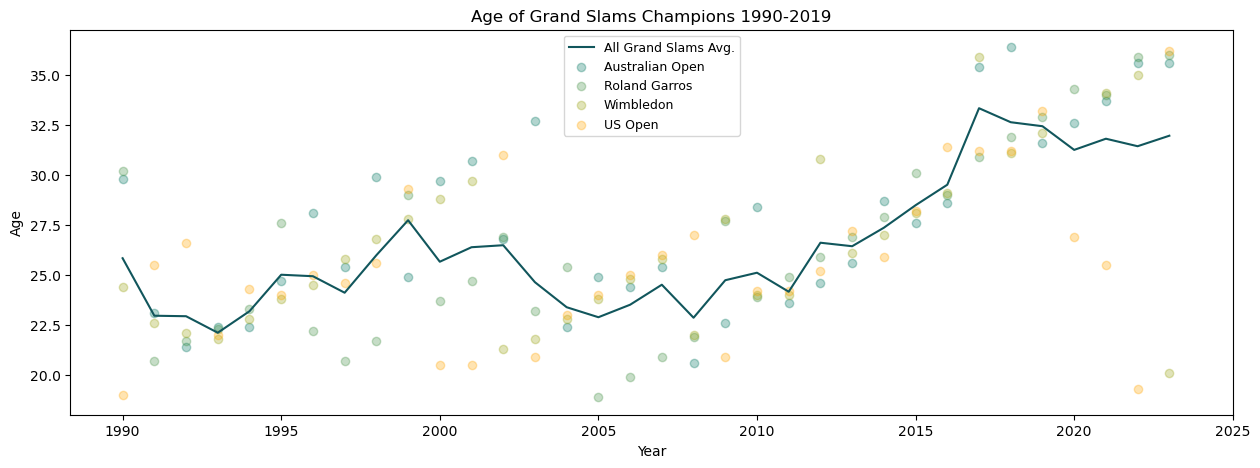

In [11]:
atp_matches=atp_matches[atp_matches['tourney_level'].isin(['G'])&(atp_matches['round']=='F')].dropna(subset=['winner_age'])
dfw = atp_matches[['tourney_year','tourney_name','winner_name','winner_age']]
dfw.columns = ['tourney_year','tourney_name','player','age']

dfs_final = dfw.groupby(['tourney_year','tourney_name']).agg({'age':'mean'}).reset_index()
dfs_final_2 = dfs_final.groupby(['tourney_year']).agg({'age':'mean'}).reset_index()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 5))))

plt.title('Age of Grand Slams Champions 1990-2019')
plt.ylabel('Age')
plt.xlabel('Year')

plt.plot(dfs_final_2['tourney_year'], dfs_final_2['age'], color=colors[0])
plt.scatter(dfs_final[dfs_final['tourney_name']=='Australian Open']['tourney_year'], dfs_final[dfs_final['tourney_name']=='Australian Open']['age'],color=colors[1] , alpha=0.3)
plt.scatter(dfs_final[dfs_final['tourney_name']=='Roland Garros']['tourney_year'], dfs_final[dfs_final['tourney_name']=='Roland Garros']['age'], color=colors[2], alpha=0.3)
plt.scatter(dfs_final[dfs_final['tourney_name']=='Wimbledon']['tourney_year'], dfs_final[dfs_final['tourney_name']=='Wimbledon']['age'], color=colors[3], alpha=0.3)
plt.scatter(dfs_final[dfs_final['tourney_name']=='US Open']['tourney_year'], dfs_final[dfs_final['tourney_name']=='US Open']['age'], color=colors[4], alpha=0.3)

plt.legend(['All Grand Slams Avg.','Australian Open', 'Roland Garros', 'Wimbledon', 'US Open'], loc='upper center',prop={'size': 9})
plt.xticks(np.arange(1990, 2026, 5), np.arange(1990, 2026, 5))

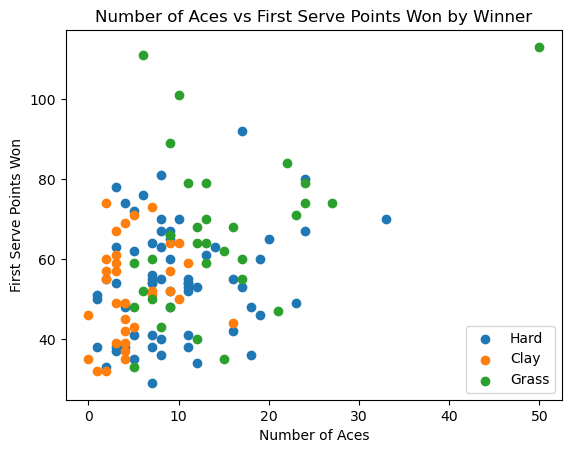

In [12]:
hard_surface = atp_matches[atp_matches['surface'] == 'Hard']
clay_surface = atp_matches[atp_matches['surface'] == 'Clay']
grass_surface = atp_matches[atp_matches['surface'] == 'Grass']

plt.scatter(hard_surface['w_ace'], hard_surface['w_1stWon'], label='Hard')
plt.scatter(clay_surface['w_ace'], clay_surface['w_1stWon'], label='Clay')
plt.scatter(grass_surface['w_ace'], grass_surface['w_1stWon'], label='Grass')

plt.title('Number of Aces vs First Serve Points Won by Winner')
plt.xlabel('Number of Aces')
plt.ylabel('First Serve Points Won')

plt.legend()

plt.show()

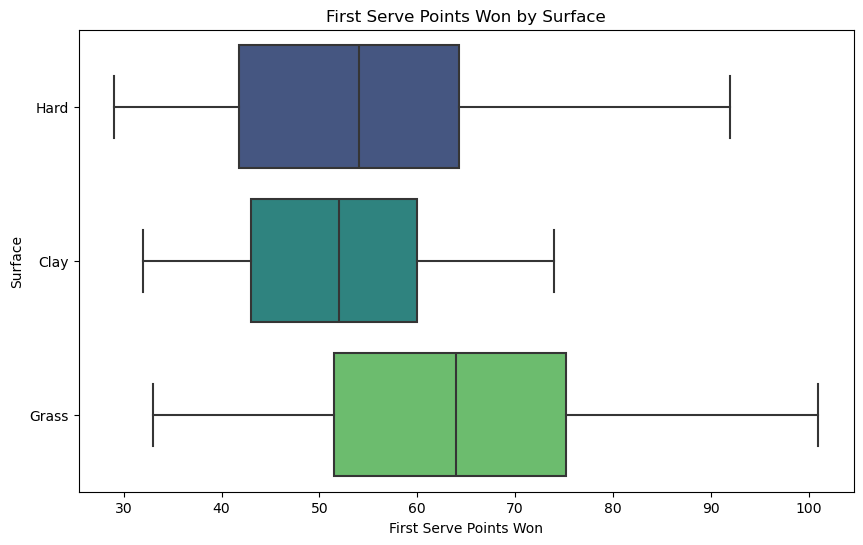

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='w_1stWon', y='surface', data=atp_matches, palette='viridis', showfliers=False)
plt.xlabel('First Serve Points Won')
plt.ylabel('Surface')
plt.title('First Serve Points Won by Surface')
plt.show()

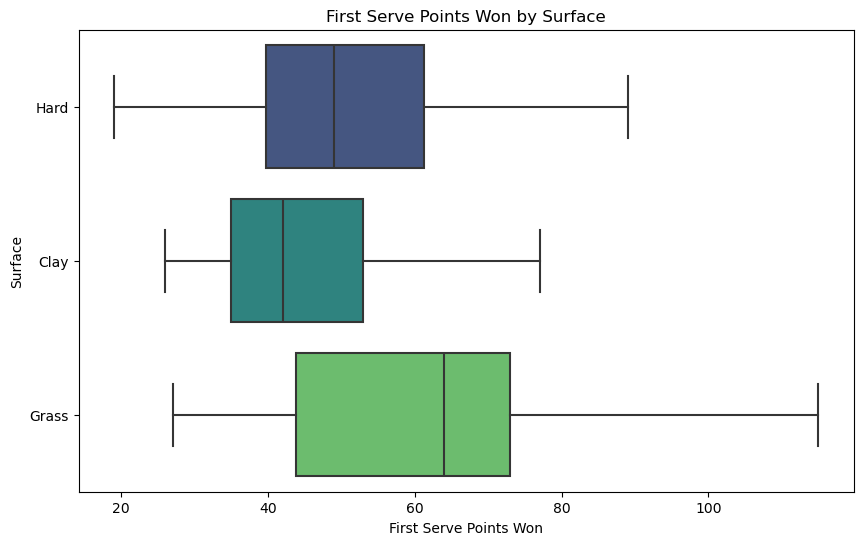

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='l_1stWon', y='surface', data=atp_matches, palette='viridis', showfliers=False)
plt.xlabel('First Serve Points Won')
plt.ylabel('Surface')
plt.title('First Serve Points Won by Surface')
plt.show()